# 比較氣象資料的預測值與觀測值

專案本身是經由氣象預報資料預測氣象觀測資料，再由氣象觀測資料預測電力資料，這份筆記本的目的是驗證現行主力模型對於氣象觀測資料的預測成績。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
#這兩行讓 matplotlib 的圖可以顯示中文，同時正常顯示負號
matplotlib.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False
import datetime

In [2]:
data_path = './historical/data/'

In [3]:
town_and_station = {
    '臺北市中正區': '臺北',
    '高雄市楠梓區': '高雄',
    '嘉義市西區': '嘉義',
    '澎湖縣望安鄉': '東吉島',
    '臺中市龍井區': '臺中電廠',
    '雲林縣臺西鄉': '臺西'
}

In [4]:
selected_stations = ['臺北', '高雄', '嘉義', '東吉島', '臺中電廠']

## 讀取並整理氣象預報、模型預測以及實際觀測的資料

### forecast_interpret 函式

forecast_interpret 這個函式利用直觀方法將原始的每三個小時一次的紀錄轉換成全天的紀錄  
比如某天高雄市楠梓區有 0 點到 21 點共八筆溫度預報資料，函式的直觀方法將取八筆的最高值為當天最高氣溫預報值，最低值為最低氣溫預報值，平均值為氣溫預報值

In [5]:
def forecast_interpret(forecast_df, first_date):
    def get_related_columns(columns, feature):
        feature_str = feature
        if '氣溫' in feature:
            feature_str = '溫度'
        result = []
        for col in columns:
            if col.split('_')[0] == feature_str:
                result.append(col)
        return result
        
    interpretation_dict = {
        '日期': [],
        '站名': [],
        '氣溫': [],
        '最低氣溫': [],
        '最高氣溫': [],
        '風速': [],
    }

    feature_list = list(interpretation_dict.keys())
    feature_list.remove('日期')
    feature_list.remove('站名')

    forecast_df = forecast_df[forecast_df['日期']>=first_date]
    
    for i in forecast_df.index:
        this_series = forecast_df.loc[i]
        interpretation_dict['日期'].append(this_series['日期'])
        interpretation_dict['站名'].append(town_and_station[this_series['鄉鎮']])
        for feature in feature_list:
            this_f_series = this_series[get_related_columns(forecast_df.columns, feature)]
            try:
                if feature in ['氣溫', '風速']:
                    this_val = np.nanmean(list(this_f_series))
                elif feature == '最高氣溫':
                    this_val = np.nanmax(list(this_f_series))
                elif feature == '最低氣溫':
                    this_val = np.nanmin(list(this_f_series))
            except:
                this_val = np.nan
            interpretation_dict[feature].append(this_val)
    return pd.DataFrame(interpretation_dict)

### Extract and Transform

In [6]:
def select_station(df, selected_stations):
    df_list = []
    for station in selected_stations:
        df_list.append(df[df['站名']==station])
    return pd.concat(df_list, axis=0, ignore_index=True)

In [7]:
w_pred_df = pd.read_csv(f'{data_path}prediction/weather.csv')
w_obs_df = pd.read_csv(f'{data_path}weather/finalized/big_table.csv')
w_forecast_df = pd.read_csv(f'{data_path}weather/finalized/weather_forecast.csv')

w_pred_df['日期'] = pd.to_datetime(w_pred_df['日期'])

w_obs_df['日期'] = pd.to_datetime(w_obs_df['日期'])
w_obs_df.sort_values('日期', inplace=True)
w_obs_df.reset_index(drop=True, inplace=True)
col_map = {col: col.split('(')[0] for col in w_obs_df.columns}
w_obs_df.rename(col_map, axis=1, inplace=True)
w_obs_df = w_obs_df[w_pred_df.columns]

w_forecast_df['日期'] = pd.to_datetime(w_forecast_df['日期'])

w_forecast_interp_df = forecast_interpret(w_forecast_df, first_date=min(w_pred_df['日期']))

In [8]:
w_obs_df = select_station(w_obs_df, selected_stations)

In [9]:
display(w_forecast_df.tail(10))
display(w_pred_df.tail(10))
display(w_obs_df.tail(10))
display(w_forecast_interp_df.tail(10))

,鄉鎮,日期,晴_0,多雲_0,陰_0,短暫陣雨_0,短暫陣雨或雷雨_0,午後短暫雷陣雨_0,陣雨或雷雨_0,溫度_0,...,陰_21,短暫陣雨_21,短暫陣雨或雷雨_21,午後短暫雷陣雨_21,陣雨或雷雨_21,溫度_21,降水機率_21,相對溼度_21,風速_21,風向_21
326,雲林縣臺西鄉,2024-08-26,1,0,0,0,0,0,0,27,...,0,0,0,0,0,28,0.1,90,1,215
327,雲林縣臺西鄉,2024-08-27,1,0,0,0,0,0,0,27,...,0,0,0,0,0,28,0.1,91,1,180
328,雲林縣臺西鄉,2024-08-28,0,0,1,0,0,0,0,28,...,0,0,0,0,0,29,0.1,91,1,180
329,雲林縣臺西鄉,2024-08-29,1,0,0,0,0,0,0,28,...,0,0,0,0,0,28,0.1,90,1,180
330,雲林縣臺西鄉,2024-08-30,1,0,0,0,0,0,0,28,...,0,0,0,0,0,28,0.1,90,1,135
331,雲林縣臺西鄉,2024-08-31,1,0,0,0,0,0,0,27,...,0,0,0,0,0,28,0.1,90,1,90
332,雲林縣臺西鄉,2024-09-01,1,0,0,0,0,0,0,28,...,0,0,0,0,0,28,0.2,91,1,135
333,雲林縣臺西鄉,2024-09-02,1,0,0,0,0,0,0,28,...,0,0,0,0,0,29,0.1,89,1,180
334,雲林縣臺西鄉,2024-09-03,1,0,0,0,0,0,0,28,...,0,0,0,0,0,29,0.2,84,1,360
335,雲林縣臺西鄉,2024-09-04,0,1,0,0,0,0,0,28,...,0,0,0,0,0,29,0.2,88,3,180


,日期,站名,日照率,最低氣溫,最高氣溫,氣溫,風速,全天空日射量
194,2024-09-02,臺中電廠,70.425507,27.047111,32.116543,29.285208,2.056481,22.418236
195,2024-09-02,東吉島,79.335342,27.584847,32.483177,29.450956,2.421443,24.139955
196,2024-09-02,嘉義,70.333710,26.057413,33.619820,29.380178,1.554114,22.390044
197,2024-09-02,高雄,81.342705,27.024076,33.187565,29.768011,1.223966,24.518927
198,2024-09-03,臺西,80.354027,26.790666,32.088200,29.172279,2.062930,24.334403
199,2024-09-03,臺中電廠,76.954437,26.953715,33.109745,29.605324,2.261469,23.679837
200,2024-09-03,東吉島,73.941002,27.545271,32.027615,29.363217,4.882862,23.080451
201,2024-09-03,嘉義,72.907700,26.057413,33.619820,29.380178,1.595340,22.882640
202,2024-09-03,高雄,65.256187,26.953715,33.109745,29.605324,1.426580,21.382158
203,2024-09-03,臺北,64.471321,27.241296,34.592834,30.022215,2.597401,21.255575


,日期,站名,日照率,最低氣溫,最高氣溫,氣溫,風速,全天空日射量
3045,2024-08-24,臺中電廠,NaN,27.2,33.4,30.0,1.5,NaN
3046,2024-08-25,臺中電廠,NaN,26.2,32.6,29.5,1.5,NaN
3047,2024-08-26,臺中電廠,NaN,27.4,32.3,29.4,1.7,NaN
3048,2024-08-27,臺中電廠,NaN,27.3,33.5,30.3,1.5,NaN
3049,2024-08-28,臺中電廠,NaN,27.4,34.3,30.9,1.5,NaN
3050,2024-08-29,臺中電廠,NaN,27.8,32.5,30.6,1.7,NaN
3051,2024-08-30,臺中電廠,NaN,27.6,32.3,30.3,2.1,NaN
3052,2024-08-31,臺中電廠,NaN,28.7,31.6,30.1,2.3,NaN
3053,2024-09-01,臺中電廠,NaN,28.2,31.7,29.9,1.7,NaN
3054,2024-09-02,臺中電廠,NaN,27.3,32.9,30.2,1.9,NaN


,日期,站名,氣溫,最低氣溫,最高氣溫,風速
200,2024-08-26,臺西,28.625,26,31,1.125
201,2024-08-27,臺西,29.000,26,32,1.750
202,2024-08-28,臺西,29.375,27,32,2.000
203,2024-08-29,臺西,29.250,27,32,2.000
204,2024-08-30,臺西,29.250,27,32,1.500
205,2024-08-31,臺西,29.000,26,32,1.500
206,2024-09-01,臺西,29.125,26,32,2.500
207,2024-09-02,臺西,29.375,27,32,1.375
208,2024-09-03,臺西,29.375,27,32,2.000
209,2024-09-04,臺西,29.500,27,33,1.875


### 合併資料，並選出日期與站名的交集

In [10]:
w_pred_obs_df = pd.merge(w_pred_df, w_obs_df, on=['日期', '站名'], how='inner', suffixes=['_預測','_觀測'])
w_forecast_obs_df = pd.merge(w_forecast_interp_df, w_obs_df, on=['日期', '站名'], how='inner', suffixes=['_預報','_觀測'])
w_forecast_obs_df.drop(['全天空日射量', '日照率'],axis=1 , inplace=True)
display(w_pred_obs_df.tail(15))
display(w_forecast_obs_df.tail(15))

,日期,站名,日照率_預測,最低氣溫_預測,最高氣溫_預測,氣溫_預測,風速_預測,全天空日射量_預測,日照率_觀測,最低氣溫_觀測,最高氣溫_觀測,氣溫_觀測,風速_觀測,全天空日射量_觀測
150,2024-08-31,高雄,64.166008,26.613052,33.113369,29.490537,1.175656,21.187311,62.9,26.5,33.9,29.6,1.2,20.94
151,2024-08-31,臺中電廠,80.414429,27.047111,32.116543,29.285208,1.453019,24.387946,NaN,28.7,31.6,30.1,2.3,NaN
152,2024-08-31,東吉島,74.975113,27.024212,31.615589,28.917278,2.068938,23.306870,93.9,27.9,31.7,29.5,3.4,27.00
153,2024-08-31,嘉義,65.275146,26.150719,32.943054,29.270136,1.658146,21.419366,74.0,26.8,33.5,30.1,1.8,23.12
154,2024-08-31,臺北,78.227974,26.833683,34.557976,29.787821,1.662079,23.976688,78.5,27.5,35.7,31.0,1.7,24.03
155,2024-09-01,東吉島,79.671478,26.788573,31.872009,28.867729,2.511913,24.214323,87.6,27.2,31.7,29.2,3.2,25.76
156,2024-09-01,臺北,75.190132,27.241296,34.592834,30.022215,1.718892,23.370987,91.4,27.8,36.3,31.6,1.9,26.54
157,2024-09-01,臺中電廠,76.493385,26.397266,31.610836,28.708206,1.481088,23.611977,NaN,28.2,31.7,29.9,1.7,NaN
158,2024-09-01,高雄,64.284508,26.691716,33.524574,29.661062,1.345501,21.204884,79.8,24.7,33.3,28.9,0.9,24.23
159,2024-09-01,嘉義,68.595291,26.163377,33.454575,29.431926,1.722249,22.059194,50.2,25.4,33.5,28.2,1.3,18.47


,日期,站名,氣溫_預報,最低氣溫_預報,最高氣溫_預報,風速_預報,最低氣溫_觀測,最高氣溫_觀測,氣溫_觀測,風速_觀測
150,2024-08-19,臺中電廠,28.625,27,30,3.875,26.4,32.3,28.4,2.3
151,2024-08-20,臺中電廠,29.250,27,31,7.000,24.6,34.6,28.4,2.5
152,2024-08-21,臺中電廠,30.250,28,33,6.125,25.9,33.6,29.5,1.8
153,2024-08-22,臺中電廠,30.000,27,33,5.375,26.6,33.2,29.9,1.3
154,2024-08-23,臺中電廠,29.500,27,32,4.375,27.5,33.2,30.4,1.3
155,2024-08-24,臺中電廠,29.500,27,32,2.125,27.2,33.4,30.0,1.5
156,2024-08-25,臺中電廠,29.375,27,32,1.375,26.2,32.6,29.5,1.5
157,2024-08-26,臺中電廠,29.375,27,32,1.250,27.4,32.3,29.4,1.7
158,2024-08-27,臺中電廠,29.375,27,32,2.625,27.3,33.5,30.3,1.5
159,2024-08-28,臺中電廠,29.875,27,33,2.875,27.4,34.3,30.9,1.5


## 實際比較

In [18]:
def R2(XT, XP):
    return 1 - np.nanvar(XT-XP)/np.nanvar(XT)
def MAE(XT, XP):
    return np.nanmean(np.abs(XT-XP))

In [27]:
def plot_one_axis(ax, data_df, feature, suffixes=['觀測', '預測']):
    if '氣溫' in feature:
        unit = '℃'
    elif feature == '日照率':
        unit = '%'
    elif feature == '全天空日射量':
        unit = 'MJ/㎡'
    elif feature == '風速':
        unit = 'm/s'
        
    X = np.array(data_df[f'{feature}_{suffixes[0]}'])
    Y = np.array(data_df[f'{feature}_{suffixes[1]}'])
    r2 = R2(X, Y)
    mae = MAE(X, Y)
    
    minXY = np.nanmin(np.concatenate([X, Y], axis=0))
    maxXY = np.nanmax(np.concatenate([X, Y], axis=0))
    
    ax.scatter(X, Y, X*0+5)
    ax.plot([minXY, maxXY], [minXY, maxXY], ':k')
    ax.set_title(feature)
    ax.set_xlabel(f'{suffixes[0]}({unit})')
    ax.set_ylabel(f'{suffixes[1]}({unit})')

    ax.text(minXY + (maxXY - minXY) * 0.5, minXY + (maxXY - minXY) * 0.15, f'R2 = {r2:.4f}')
    ax.text(minXY + (maxXY - minXY) * 0.5, minXY + (maxXY - minXY) * 0.08, f'MAE = {mae:.4f}{unit}')

### 模型預測 VS 實際觀測

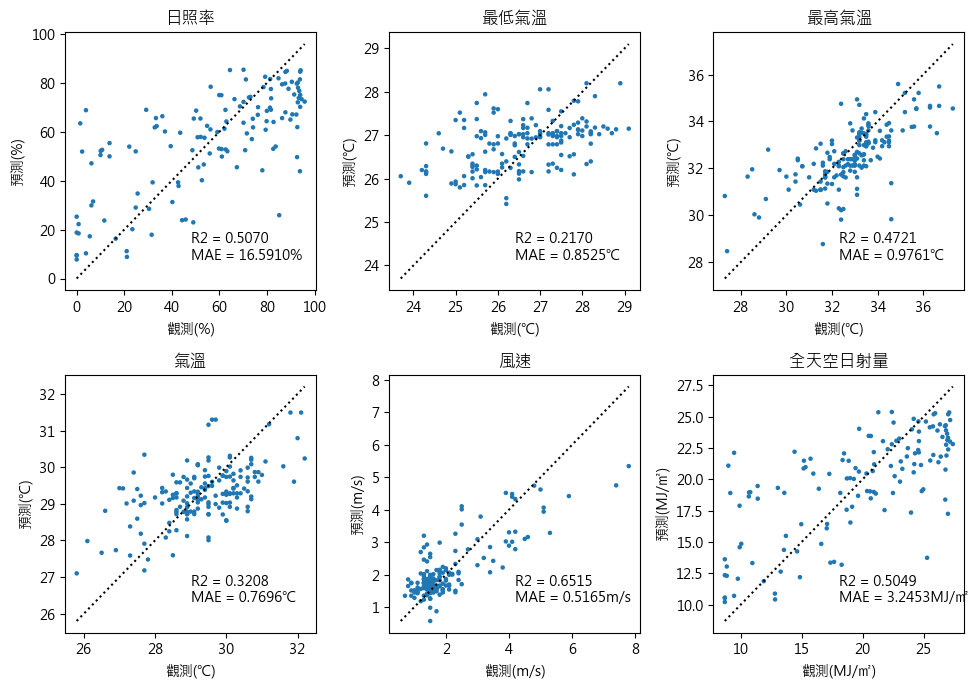

In [28]:
features = ['日照率', '最低氣溫', '最高氣溫', '氣溫', '風速', '全天空日射量']
fig, axes = plt.subplots(2, 3)
fig.set_size_inches([10,7])
for i, f in enumerate(features):
    this_ax = axes[int(i/3)][i%3]
    plot_one_axis(this_ax, w_pred_obs_df, f)
fig.tight_layout()

### 氣象署預報 VS 實際觀測

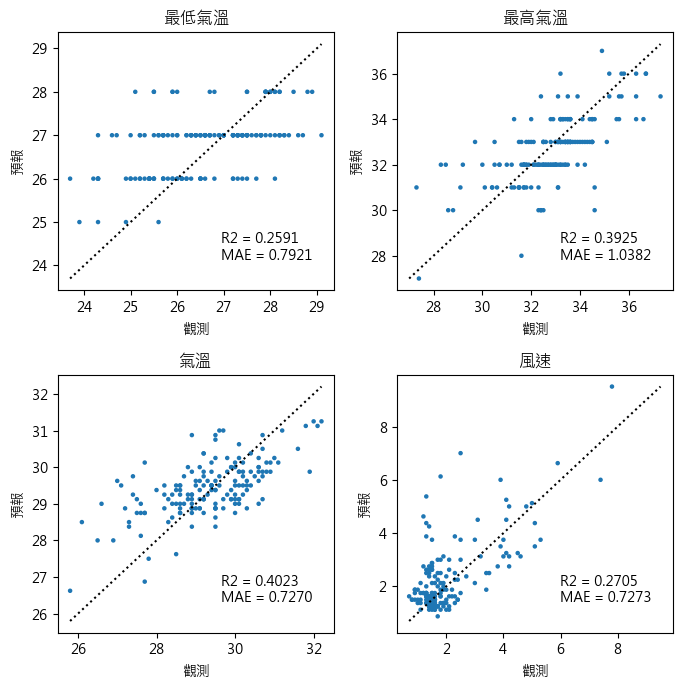

In [22]:
features = ['最低氣溫', '最高氣溫', '氣溫', '風速']
fig, axes = plt.subplots(2, 2)
fig.set_size_inches([7, 7])
for i, f in enumerate(features):
    this_ax = axes[int(i/2)][i%2]
    plot_one_axis(this_ax, w_forecast_obs_df, f, suffixes=['觀測', '預報'])
fig.tight_layout()